In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dir_path = 'D:/competition/kaggle/riiid-test-answer-prediction/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

nrows = 100 * 10000
# nrows = None
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int16',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        })
# 没有读入user_answer[-1,0,1,2,3]

lectures = pd.read_csv(
                       dir_path + file_lectures, 
                       usecols=['lecture_id','tag','part','type_of'], 
                       nrows=nrows,
                       dtype={
                           'lecture_id': 'int16',
                           'tag': 'int16',
                           'part': 'int8',
                           'type_of': 'str'
                       }
                    )
questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part','tags'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                           'tags': 'str'
                       }
                    )

# Train

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int32  
 3   content_id                      1000000 non-null  int16  
 4   content_type_id                 1000000 non-null  int8   
 5   task_container_id               1000000 non-null  int16  
 6   answered_correctly              1000000 non-null  int8   
 7   prior_question_elapsed_time     976277 non-null   float32
 8   prior_question_had_explanation  996184 non-null   object 
dtypes: float32(1), int16(2), int32(1), int64(2), int8(2), object(1)
memory usage: 36.2+ MB


In [7]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,NaN,NaN
1,1,56943,115,5716,0,2,1,37000.0,False
2,2,118363,115,128,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,1,19000.0,False
4,4,137965,115,7922,0,4,1,11000.0,False


In [8]:
train.tail()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
999995,999995,26482248,20949024,8803,0,29,1,14000.0,True
999996,999996,26516686,20949024,4664,0,30,1,17000.0,True
999997,999997,26537967,20949024,4108,0,31,0,18000.0,True
999998,999998,26590240,20949024,5014,0,32,0,6000.0,True
999999,999999,26605316,20949024,9828,0,33,0,46000.0,True


Text(0.5, 1.0, 'label dis')

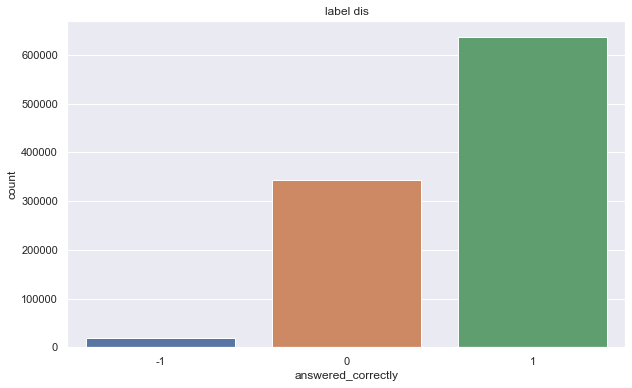

In [11]:
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='answered_correctly')
plt.title('label dis')

Text(0.5, 1.0, 'label dis')

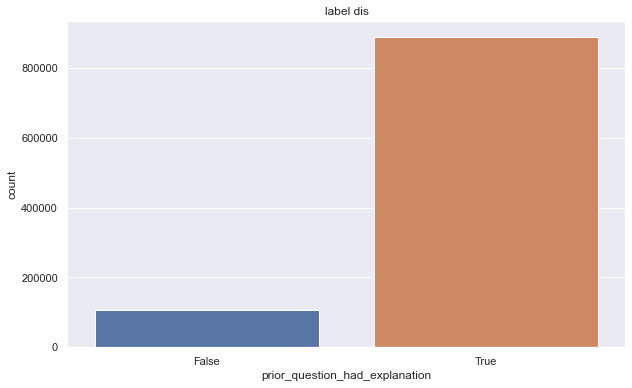

In [51]:
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='prior_question_had_explanation')
plt.title('label dis')

### content_id

Text(0.5, 1.0, 'content dis')

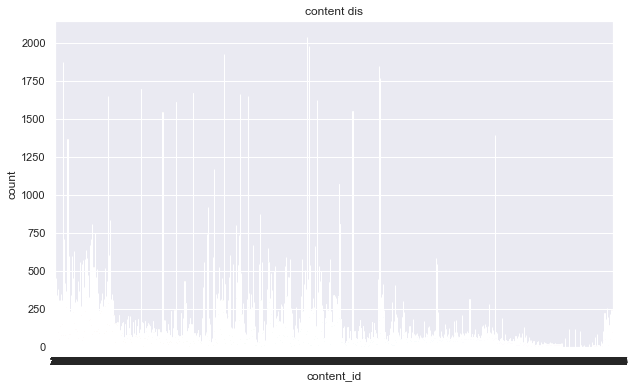

In [12]:
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='content_id')
plt.title('content dis')

In [22]:
train.groupby('content_id')['row_id'].count().sort_values()

content_id
12504       1
12945       1
12944       1
12940       1
12939       1
         ... 
7876     1847
175      1877
4120     1924
6173     1978
6116     2041
Name: row_id, Length: 13320, dtype: int64

In [38]:
a=train.groupby('content_id')['row_id'].count().sort_values()
len(a[a<=50])/len(a)

0.5168918918918919

<AxesSubplot:>

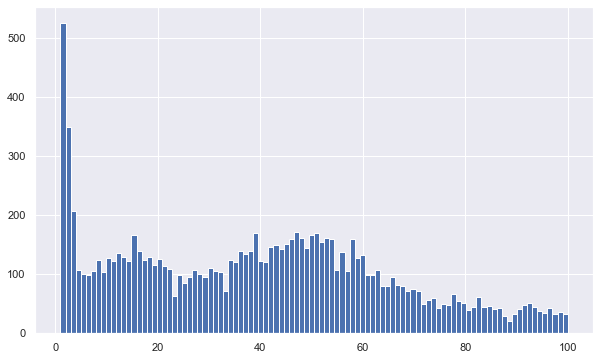

In [50]:
plt.figure(figsize=(10,6))
a[a<=100].hist(bins=100)

### user_id

In [5]:
train.groupby('user_id')['row_id'].count().sort_values().reset_index()

,user_id,row_id
0,19887248,1
1,1880240,1
2,15960740,2
3,2148001,2
4,1946295,3
...,...,...
3819,4421282,6962
3820,9418512,7482
3821,1283420,7569
3822,18122922,7593


In [6]:
train[train['user_id']==19887248]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
965193,965193,0,19887248,6368,0,0,0,NaN,NaN


In [7]:
train[train['user_id']==1946295]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
87900,87900,0,1946295,7900,0,0,1,NaN,NaN
87901,87901,23551,1946295,7876,0,1,0,26000.0,False
87902,87902,48795,1946295,175,0,2,1,20000.0,False


In [18]:
train[train['user_id']==7171715]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
366323,366323,0,7171715,4318,0,0,1,NaN,NaN
366324,366324,4274,7171715,5112,0,1,1,2000.0,False
366325,366325,7649,7171715,6143,0,2,0,1000.0,False
366326,366326,11134,7171715,5070,0,3,0,1000.0,False
366327,366327,14275,7171715,4554,0,4,1,1000.0,False
...,...,...,...,...,...,...,...,...,...
377144,377144,1380270562,7171715,9151,0,7735,1,20000.0,True
377145,377145,1380316755,7171715,3928,0,7736,1,7000.0,True
377146,377146,1380370703,7171715,4076,0,7737,1,23000.0,True
377147,377147,9717103856,7171715,10470,0,7738,1,30000.0,True


In [49]:
b=train.groupby('user_id')['row_id'].count().sort_values()
len(b[b==1])/len(b)

0.0005230125523012552

<AxesSubplot:>

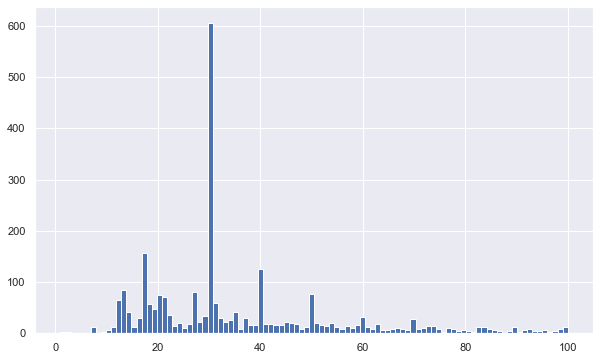

In [48]:
plt.figure(figsize=(10,6))
b[b<=100].hist(bins=100)

### task_container_id

In [39]:
train.groupby('task_container_id')['row_id'].count().sort_values()

task_container_id
7739       1
6324       1
6325       1
6326       1
6327       1
        ... 
6       6722
5       6732
4       6753
15      7806
14      7845
Name: row_id, Length: 7740, dtype: int64

In [45]:
c=train.groupby('task_container_id')['row_id'].count().sort_values()
len(c[c==1])/len(c)

0.26356589147286824

<AxesSubplot:>

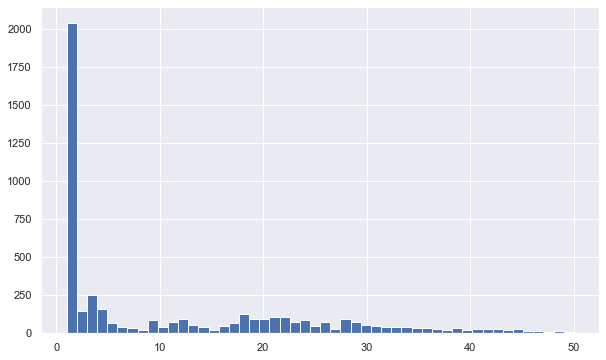

In [44]:
plt.figure(figsize=(10,6))
c[c<=50].hist(bins=50)

### prior_question_elapsed_time

Text(0.5, 1.0, 'content dis')

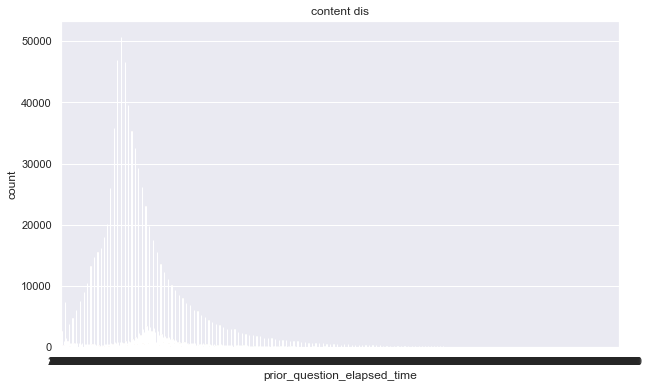

In [74]:
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='prior_question_elapsed_time')
plt.title('content dis')

In [72]:
train.groupby('prior_question_elapsed_time')['row_id'].count().sort_values()

prior_question_elapsed_time
212750.0        1
119600.0        1
150800.0        1
151500.0        1
168800.0        1
            ...  
15000.0     35889
19000.0     39580
18000.0     46550
16000.0     46949
17000.0     50744
Name: row_id, Length: 1659, dtype: int64

In [70]:
train.groupby('prior_question_elapsed_time')[['row_id']].count().reset_index().sort_values(by=['prior_question_elapsed_time'])

,prior_question_elapsed_time,row_id
0,0.0,2701
1,200.0,3
2,250.0,12
3,333.0,369
4,400.0,5
...,...,...
1654,295000.0,4
1655,296000.0,7
1656,297000.0,1
1657,298000.0,2


In [97]:
e=train[train['prior_question_elapsed_time']<=17000.0][['row_id']].count()
e[0]/len(train)

0.341002

# statistical characteristics

## answer correctness rate

### questions+lectures

In [45]:
df1=train.groupby(['user_id'])['answered_correctly'].agg([np.mean,np.std]).reset_index()
df1

,user_id,mean,std
0,115,0.695652,0.465215
1,124,0.233333,0.430183
2,2746,0.500000,0.606977
3,5382,0.632812,0.530504
4,8623,0.598214,0.544585
...,...,...,...
3819,20913319,0.560096,0.577693
3820,20913864,0.333333,0.483046
3821,20938253,0.575701,0.534720
3822,20948951,0.607843,0.493089


In [55]:
train[train['user_id']==115]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,NaN,NaN
1,1,56943,115,5716,0,2,1,37000.0,False
2,2,118363,115,128,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,1,19000.0,False
4,4,137965,115,7922,0,4,1,11000.0,False
5,5,157063,115,156,0,5,1,5000.0,False
6,6,176092,115,51,0,6,1,17000.0,False
7,7,194190,115,50,0,7,1,17000.0,False
8,8,212463,115,7896,0,8,1,16000.0,False
9,9,230983,115,7863,0,9,1,16000.0,False


In [48]:
df1.sort_values(by='mean')

,user_id,mean,std
3534,19172765,-0.013072,0.688122
226,1360462,0.000000,0.000000
3661,19887248,0.000000,NaN
1887,10442781,0.033333,0.182574
3237,17636315,0.066667,0.253708
...,...,...,...
1392,7788970,0.966667,0.182574
543,3126556,0.966667,0.182574
3510,19087497,0.967742,0.179605
1339,7528236,0.967742,0.179605


In [49]:
train[train['user_id']==19172765]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
913836,913836,0,19172765,4603,0,0,0,NaN,NaN
913837,913837,28910,19172765,4324,0,1,0,18000.0,False
913838,913838,59340,19172765,846,0,2,0,24000.0,False
913839,913839,80977,19172765,4981,0,3,1,28000.0,False
913840,913840,109829,19172765,5296,0,4,1,19000.0,False
...,...,...,...,...,...,...,...,...,...
913984,913984,6403824412,19172765,27683,1,91,-1,NaN,False
913985,913985,6475599829,19172765,18704,1,92,-1,NaN,False
913986,913986,6573882978,19172765,22357,1,93,-1,NaN,False
913987,913987,7123212945,19172765,19224,1,94,-1,NaN,False


In [50]:
df1[df1['user_id']==7171715] #做题最多的人

,user_id,mean,std
1267,7171715,0.258082,0.44368


### questions only

In [51]:
train_questions=train[train['content_type_id']==0]
df2 = train_questions.groupby(['user_id'])['answered_correctly'].agg([np.mean,np.std]).reset_index()
df2.sort_values(by='mean')

,user_id,mean,std
3661,19887248,0.000000,NaN
226,1360462,0.000000,0.000000
1887,10442781,0.033333,0.182574
2372,12975989,0.066667,0.253708
3237,17636315,0.066667,0.253708
...,...,...,...
543,3126556,0.966667,0.182574
1392,7788970,0.966667,0.182574
1339,7528236,0.967742,0.179605
3510,19087497,0.967742,0.179605


<AxesSubplot:xlabel='mean'>

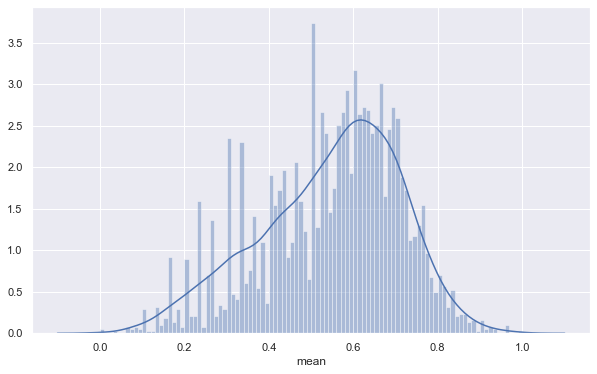

In [65]:
sns.set()
plt.figure(figsize=(10,6))
sns.distplot(df2['mean'],bins=100)
# df2['mean'].plot.density()

<AxesSubplot:xlabel='std'>

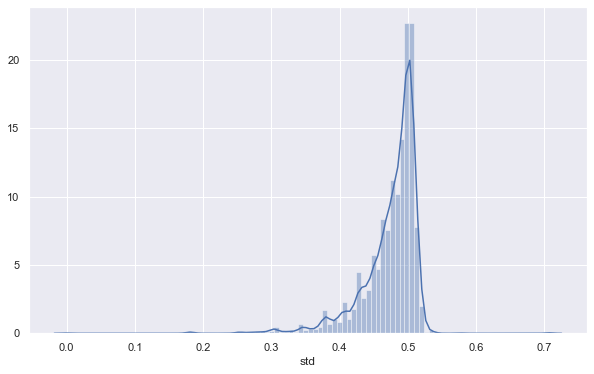

In [66]:
plt.figure(figsize=(10,6))
sns.distplot(df2['std'],bins=100)#二分类算标注差好像没什么用，0.6的准确率：标准差0.4899

In [52]:
df2[df2['user_id']==7171715] #做题最多的人,去掉lecture，也没提高多少，太惨了老哥

,user_id,mean,std
1267,7171715,0.261462,0.439451


### lectures only

In [53]:
train_questions=train[train['content_type_id']==1]
df3 = train_questions.groupby(['user_id'])['row_id'].count().reset_index()
df3.sort_values(by='row_id')

,user_id,row_id
0,2746,1
545,7314679,1
1242,17210091,1
1243,17216952,1
1244,17258119,1
...,...,...
1130,15632472,170
1297,18122922,180
5,24418,181
703,9418512,221


In [54]:
df2[df2['user_id']==19594546]

,user_id,mean,std
3602,19594546,0.704142,0.456472


In [42]:
from collections import Counter
Counter(train[train['user_id']==19594546]['content_type_id'])#也没看多少lecture，低于平均LQ比

Counter({0: 5070, 1: 306})